In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import os
import pandas as pd
from tqdm import tqdm, trange
from collections import defaultdict
import itertools
import matplotlib.pyplot as plt

In [2]:
def get_processed_tensors(data, normalize=True):
    # add direction attributes
    vehicle_mean_speed = data.groupby(['ego_id','recording_id']).ego_xVel.transform('mean')
    vehicle_abs_speed = vehicle_mean_speed.abs() 
    data['dir'] = vehicle_mean_speed / vehicle_abs_speed
    # add lane changing attributes
    ego_pre_lc = data.groupby(['ego_id','recording_id']).ego_pre_lc.transform('any')
    ego_post_lc = data.groupby(['ego_id','recording_id']).ego_post_lc.transform('any')
    ego_lc = ego_pre_lc | ego_post_lc
    foe_pre_lc = data.groupby(['foe_id','recording_id']).foe_pre_lc.transform('any')
    foe_post_lc = data.groupby(['foe_id','recording_id']).foe_post_lc.transform('any')
    foe_lc = foe_pre_lc | foe_post_lc
    data['ego_lc'] = ego_lc
    data['foe_lc'] = foe_lc
    ego_xVel = np.abs(data.ego_xVel.values)
    ego_yVel = np.abs(data.ego_yVel.values) * data.dir.values
    rel_xVel = -((data.ego_xVel - data.foe_xVel)*(data.ego_x - data.foe_x) / abs(data.ego_x - data.foe_x)).values
    rel_yVel = -((data.ego_yVel - data.foe_yVel)*(data.ego_y - data.foe_y) / abs(data.ego_y - data.foe_y)).values
    ego_lc = data.ego_lc
    foe_lc = data.foe_lc
    ego_class = data.ego_truck.values
    foe_class = data.foe_truck.values
    X = np.clip( abs(data.ego_x - data.foe_x) -  0.5*(data.ego_length - data.foe_length), a_min=0, a_max=None).values *((data.foe_x - data.ego_x) / abs(data.ego_x - data.foe_x)).values * data.dir.values
    Y = np.clip( abs(data.ego_y - data.foe_y) -  0.5*(data.ego_width - data.foe_width), a_min=0, a_max=None).values *((data.foe_y - data.ego_y) / abs(data.ego_y - data.foe_y)).values * data.dir.values
    np.nan_to_num(X, 0)
    np.nan_to_num(Y, 0)
    X = torch.Tensor(X).to('cuda').detach()
    Y = torch.Tensor(Y).to('cuda').detach()
    Input = np.array(
    [
        ego_xVel, ego_yVel, rel_xVel, rel_yVel, ego_lc, foe_lc, ego_class, foe_class
    ]
    ).T
    np.nan_to_num(Input, 0)
    Input = torch.Tensor(Input).to('cuda')
    if normalize:
        Input[:,0] = Input[:,0] / torch.quantile(Input[:,0], 0.95)
        Input[:,1] = Input[:,1] / 1
        Input[:,2] = Input[:,2] / 15
        Input[:,2] = Input[:,2] / 1.25
    dataset = torch.cat([Input, X.view(-1,1)], dim=1)
    dataset = torch.cat([dataset, Y.view(-1,1)], dim=1)
    return dataset

In [171]:
data_path = "D:/Productivity/Projects/RiskFieldImitation-main/data"
print (f"---- Reading raw data ----")
full_data = pd.concat([ pd.read_csv(f"{data_path}/{r:02}_spacings_2.csv",index_col=0) for r in trange(1,61)])
print (f"---- Generating tensor ----")
full_data = get_processed_tensors(full_data)

---- Reading raw data ----


100%|██████████| 60/60 [00:05<00:00, 10.59it/s]


---- Generating tensor ----


In [67]:

def remove_similar_data(data, epsilon=0.1):
    """
    Remove similar data points by keeping only one representative per group.
    
    Args:
        data (torch.Tensor): (N, D) tensor of data points.
        epsilon (float): Distance threshold to consider points as similar.

    Returns:
        torch.Tensor: Filtered tensor with reduced similar points.
    """
    device = data.device  # Ensure we work on the correct device
    remaining_indices = torch.arange(data.shape[0], device=device)  # Track remaining indices
    selected_points = []  # Store filtered points

    # Use tqdm for a progress bar
    with tqdm(total=data.shape[0], desc="Processing", unit="samples") as pbar:
        while remaining_indices.numel() > 0:
            ref_idx = remaining_indices[0]  # Take the first available index
            ref_point = data[ref_idx].unsqueeze(0)  # Reshape for broadcasting
            selected_points.append(ref_point.squeeze(0))  # Keep the reference point

            # Compute distances between the reference point and remaining points
            distances = torch.norm(data[remaining_indices] - ref_point, dim=1)

            # Keep only points that are farther than epsilon
            mask = distances >= epsilon
            remaining_indices = remaining_indices[mask]  # Filter indices

            # Update progress bar
            pbar.update(len(data) - len(remaining_indices))

    return torch.stack(selected_points)



In [71]:
_data = data
norm_x = 20
norm_y = 5
_data[:,8] = _data[:,8]/norm_x
_data[:,9] = _data[:,9]/norm_y

In [87]:
len(data[data[:,1]==0])

405859

In [69]:
reduced_data = torch.stack(list(remove_similar_data(_data, epsilon=0.1)))

Processing: 42962513607samples [02:08, 333566756.97samples/s]                  


KeyboardInterrupt: 

In [54]:
data = reduced_data

In [182]:
data = torch.load(r"D:\Productivity\Projects\RiskFieldImitation-main\data\reduced_data").to('cuda')

In [130]:
# Define bin interval
interval = 0.1
# Define the feature dimensions to calculate the similarity
feature_dims = [0,1,2,3,4,5,6,7]
# Compute bin indices for the first 8 dimensions
bin_indices = torch.floor(data[:, feature_dims] / interval).int()  # Convert to integer bins
# Convert to tuples to use as dictionary keys
bin_keys = [tuple(row.tolist()) for row in tqdm(bin_indices)]
# Create a dictionary to store groups
grouped_data = defaultdict(list)
# Group indices based on bin keys
for idx, key in enumerate(tqdm(bin_keys)):
    grouped_data[key].append(idx)
# Convert lists to tensors for efficient access
grouped_data = {k: torch.tensor(v, dtype=torch.long) for k, v in tqdm(grouped_data.items())}


  4%|▍         | 45615/1208443 [00:02<01:11, 16324.40it/s]


KeyboardInterrupt: 

In [166]:
def find_neighbors_batch(data, query_point, epsilons=[0.1,0.15], mu=100, search_dims=[0,1,2,3,4,6,7], batch_size=10000, k=0):
    """
    Find all points in 'data' within 'epsilon' distance of 'query_point' using brute-force search.
    """
    num_samples = data.shape[0]
    indices_list = [] 
    for i in range(0, num_samples, batch_size):
        bound = i + batch_size if i+batch_size < num_samples else num_samples
        batch = data[i:bound] 
        distances = torch.norm(batch[:,search_dims] - query_point[search_dims], dim=1)
        mask = distances <= epsilons[k]
        found_indices = torch.nonzero(mask, as_tuple=True)[0] + i
        indices_list.append(found_indices.to('cuda'))
    indices = torch.cat(indices_list) if indices_list else torch.tensor([]).to('cuda')
    # _k = k+1
    # print (epsilons[k])
    # if len(indices)<mu and _k<len(epsilons):
    #     indices = find_neighbors_batch(data, query_point, epsilons=epsilons, mu=mu, search_dims=search_dims, batch_size=batch_size, k=_k)
    return indices
    

In [177]:
idx = 92483
query_point = data[idx]
indices = find_neighbors_batch(data=data, query_point=query_point, batch_size=len(data))

In [172]:
idx = 92483
query_point = data[idx]
indices = find_neighbors_batch(data=full_data, query_point=query_point, batch_size=len(data))

In [178]:
query_point

tensor([ 0.6032, -0.0100,  0.5616, -0.4600,  0.0000,  1.0000,  0.0000,  0.0000,
        -3.3295, -0.1460], device='cuda:0')

In [179]:
neighbors = data[indices]
neighbor_x = neighbors[:,8]*20
neighbor_y = neighbors[:,9]*5

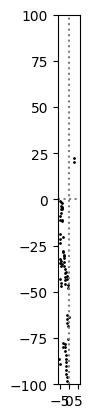

In [180]:
plt.scatter(neighbor_y.cpu(), neighbor_x.cpu(), color='black', s=1)
plt.ylim(-100, 100)
plt.xlim(-6, 6)
plt.axhline(0, linestyle='dotted', color='grey')
plt.axvline(0, linestyle='dotted', color='grey')
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')

In [184]:
neighbor_indices = [ find_neighbors_batch(data, data[k], batch_size=100000000) for k in trange(len(data))  ]

100%|██████████| 1208443/1208443 [06:31<00:00, 3090.31it/s]


In [198]:
torch.save(neighbor_indices, 'D:/Productivity/Projects/RiskFieldImitation-main/data/reduced_neighbor_indices')

In [191]:
len(neighbor_indices[8874])

1283

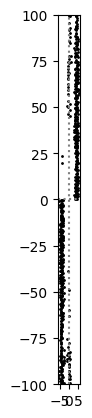

In [195]:
idx = 8874
neighbors = data[neighbor_indices[idx]]
neighbor_x = neighbors[:,8]*20
neighbor_y = neighbors[:,9]*5
plt.scatter(neighbor_y.cpu(), neighbor_x.cpu(), color='black', s=1)
plt.ylim(-100, 100)
plt.xlim(-6, 6)
plt.axhline(0, linestyle='dotted', color='grey')
plt.axvline(0, linestyle='dotted', color='grey')
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')

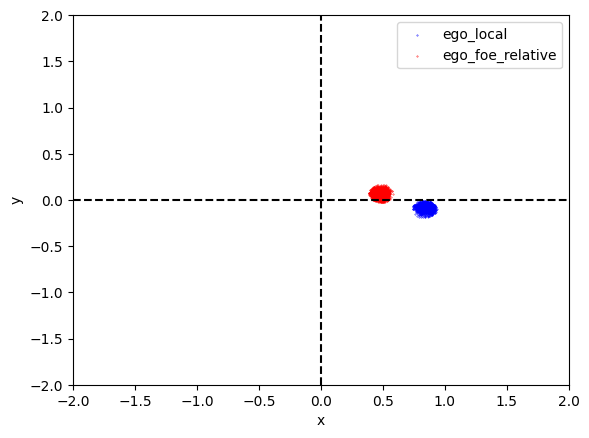

In [197]:
plt.scatter(neighbors[:,0].cpu(), neighbors[:,1].cpu(), color='blue', s=0.1, label='ego_local')
plt.scatter(neighbors[:,2].cpu(), neighbors[:,3].cpu(), color='red', s=0.1, label='ego_foe_relative')
plt.axhline(0, linestyle='dashed', color='black')
plt.axvline(0, linestyle='dashed', color='black')
plt.ylim(-2,2)
plt.xlim(-2,2)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

In [6]:

# Function to get top-k neighbors within epsilon using bins
def find_neighbors(data, grouped_data, bin_indices, batch_size=10000, epsilon=0.20, k=100, feature_dims = [0,1,2,3,4,5,6,7]):
    neighbor_dict = {}
    N = len(data)
    # Process data in batches to maximize GPU parallelism
    for i in range(0, N, batch_size):
        batch_data = data[i:i+batch_size]  # Extract batch
        batch_bins = bin_indices[i:i+batch_size]
        # Convert batch bins to tuple keys
        batch_keys = [tuple(row.tolist()) for row in batch_bins]

        # Get all potential neighbor indices from adjacent bins
        candidate_indices = []
        for key in batch_keys:
            adjacent_bins = list(itertools.product(
                *[(key[j] - 1, key[j], key[j] + 1) for j in range(len(feature_dims))]
            ))
            for adj_bin in adjacent_bins:
                if adj_bin in grouped_data:
                    candidate_indices.extend(grouped_data[adj_bin].tolist())

        if not candidate_indices:
            continue  # Skip if no neighbors

        candidate_indices = torch.tensor(candidate_indices, device="cuda")
        candidate_data = data[candidate_indices]  # Retrieve full data

        # Compute distances in parallel for the entire batch
        distances = torch.cdist(batch_data[:,feature_dims], candidate_data[feature_dims])

        # Get top-k nearest neighbors under epsilon
        mask = distances < epsilon
        top_k_indices = torch.argsort(distances, dim=1)[:, :k]  # Sort and take top-k

        # Store results in a dictionary
        for j in trange(batch_data.shape[0]):
            valid_neighbors = candidate_indices[top_k_indices[j][mask[j, top_k_indices[j]]]]
            neighbor_dict[i + j] = valid_neighbors.tolist()

    return neighbor_dict




In [7]:
# get all indices
all_indices = find_neighbors(data, grouped_data=grouped_data, batch_size=1000000,feature_dims=feature_dims)

TypeError: find_neighbors() missing 1 required positional argument: 'bin_indices'

In [10]:
i= 5000
batch_size = 15000
batch_data = data[i:i+batch_size]
batch_bins = bin_indices[i:i+batch_size]

In [16]:
idx = 500232
key = bin_indices[idx]
# adjacent_bins = list(itertools.product(
#                 *[(key[j] - 1, key[j], key[j] + 1) for j in range(len(feature_dims))]
#             ))
[(key[j] - 1, key[j], key[j] + 1) for j in range(len(feature_dims))]


[(tensor(6, device='cuda:0', dtype=torch.int32),
  tensor(7, device='cuda:0', dtype=torch.int32),
  tensor(8, device='cuda:0', dtype=torch.int32)),
 (tensor(-2, device='cuda:0', dtype=torch.int32),
  tensor(-1, device='cuda:0', dtype=torch.int32),
  tensor(0, device='cuda:0', dtype=torch.int32)),
 (tensor(0, device='cuda:0', dtype=torch.int32),
  tensor(1, device='cuda:0', dtype=torch.int32),
  tensor(2, device='cuda:0', dtype=torch.int32)),
 (tensor(0, device='cuda:0', dtype=torch.int32),
  tensor(1, device='cuda:0', dtype=torch.int32),
  tensor(2, device='cuda:0', dtype=torch.int32)),
 (tensor(-1, device='cuda:0', dtype=torch.int32),
  tensor(0, device='cuda:0', dtype=torch.int32),
  tensor(1, device='cuda:0', dtype=torch.int32)),
 (tensor(-1, device='cuda:0', dtype=torch.int32),
  tensor(0, device='cuda:0', dtype=torch.int32),
  tensor(1, device='cuda:0', dtype=torch.int32)),
 (tensor(-1, device='cuda:0', dtype=torch.int32),
  tensor(0, device='cuda:0', dtype=torch.int32),
  tensor(

In [ ]:
batch_data = data[i:i+batch_size]  # Extract batch
        batch_bins = bin_indices[i:i+batch_size]
        # Convert batch bins to tuple keys
        batch_keys = [tuple(row.tolist()) for row in batch_bins]

        # Get all potential neighbor indices from adjacent bins
        candidate_indices = []
        for key in batch_keys:
            adjacent_bins = list(itertools.product(
                *[(key[j] - 1, key[j], key[j] + 1) for j in range(len(feature_dims))]
            ))
            for adj_bin in adjacent_bins:
                if adj_bin in grouped_data:
                    candidate_indices.extend(grouped_data[adj_bin].tolist())

tensor([[ 9,  0, -2,  1,  0,  0,  0,  0],
        [ 9,  0,  6,  0,  0,  0,  0, 10],
        [ 9,  0,  6,  0,  0,  0,  0, 10],
        [ 9,  0, -2,  1,  0,  0,  0,  0],
        [ 9,  0,  6,  1,  0,  0,  0, 10],
        [ 9,  0, -7,  0,  0,  0,  0, 10],
        [ 9,  0, -2,  1,  0,  0,  0,  0],
        [ 9,  0,  6,  1,  0,  0,  0, 10],
        [ 9,  0, -7,  0,  0,  0,  0, 10],
        [ 9,  0, -2,  1,  0,  0,  0,  0],
        [ 9,  0,  6,  1,  0,  0,  0, 10],
        [ 9,  0, -7,  0,  0,  0,  0, 10],
        [ 9,  0, -2,  1,  0,  0,  0,  0],
        [ 9,  0,  6,  1,  0,  0,  0, 10],
        [ 9,  0, -7,  0,  0,  0,  0, 10],
        [ 9,  0, -2,  1,  0,  0,  0,  0],
        [ 9,  0,  6,  1,  0,  0,  0, 10],
        [ 9,  0, -7,  0,  0,  0,  0, 10],
        [ 9,  0, -2,  1,  0,  0,  0,  0],
        [ 9,  0,  6,  1,  0,  0,  0, 10],
        [ 9,  0, -7,  0,  0,  0,  0, 10],
        [ 9,  0, -2,  1,  0,  0,  0,  0],
        [ 9,  0,  6,  1,  0,  0,  0, 10],
        [ 9,  0, -7,  0,  0,  0,  